In [0]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [0]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [0]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 1, 28, 28])

In [0]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur & Config

In [0]:
from jcopdl.layers import linear_block

In [0]:
class FashionNet(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()        
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(x)

In [0]:
config = set_config({
    "input_size": 784,
    "output_size": len(label2cat),
    "n1": 256,
    "n2": 64,
    "dropout": 0.15,
    "batch_size": bs,
    "labels": label2cat
})

# Training Preparation -> MCOC

In [0]:
model = FashionNet(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config)

# Training

In [0]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.7164 | Test_cost  = 0.4813 | Train_score = 0.7489 | Test_score = 0.8245 |




Epoch     2
Train_cost  = 0.4635 | Test_cost  = 0.3928 | Train_score = 0.8355 | Test_score = 0.8550 |




Epoch     3
Train_cost  = 0.4135 | Test_cost  = 0.3798 | Train_score = 0.8518 | Test_score = 0.8598 |




Epoch     4
Train_cost  = 0.3792 | Test_cost  = 0.3566 | Train_score = 0.8647 | Test_score = 0.8710 |




Epoch     5
Train_cost  = 0.3576 | Test_cost  = 0.3492 | Train_score = 0.8714 | Test_score = 0.8709 |
==> EarlyStop patience =  1 | Best test_score: 0.8710




Epoch     6
Train_cost  = 0.3452 | Test_cost  = 0.3289 | Train_score = 0.8759 | Test_score = 0.8778 |




Epoch     7
Train_cost  = 0.3298 | Test_cost  = 0.3250 | Train_score = 0.8808 | Test_score = 0.8801 |




Epoch     8
Train_cost  = 0.3207 | Test_cost  = 0.3210 | Train_score = 0.8833 | Test_score = 0.8815 |




Epoch     9
Train_cost  = 0.3067 | Test_cost  = 0.3199 | Train_score = 0.8884 | Test_score = 0.8815 |
==> EarlyStop patience =  1 | Best test_score: 0.8815




Epoch    10
Train_cost  = 0.2970 | Test_cost  = 0.3114 | Train_score = 0.8924 | Test_score = 0.8861 |




Epoch    11
Train_cost  = 0.2902 | Test_cost  = 0.3100 | Train_score = 0.8944 | Test_score = 0.8856 |
==> EarlyStop patience =  1 | Best test_score: 0.8861




Epoch    12
Train_cost  = 0.2807 | Test_cost  = 0.3237 | Train_score = 0.8976 | Test_score = 0.8801 |
==> EarlyStop patience =  2 | Best test_score: 0.8861




Epoch    13
Train_cost  = 0.2722 | Test_cost  = 0.3307 | Train_score = 0.8999 | Test_score = 0.8772 |
==> EarlyStop patience =  3 | Best test_score: 0.8861




Epoch    14
Train_cost  = 0.2692 | Test_cost  = 0.3137 | Train_score = 0.9008 | Test_score = 0.8871 |




Epoch    15
Train_cost  = 0.2595 | Test_cost  = 0.3173 | Train_score = 0.9037 | Test_score = 0.8834 |
==> EarlyStop patience =  1 | Best test_score: 0.8871




Epoch    16
Train_cost  = 0.2550 | Test_cost  = 0.3131 | Train_score = 0.9065 | Test_score = 0.8880 |




Epoch    17
Train_cost  = 0.2490 | Test_cost  = 0.3051 | Train_score = 0.9079 | Test_score = 0.8899 |




Epoch    18
Train_cost  = 0.2412 | Test_cost  = 0.3116 | Train_score = 0.9107 | Test_score = 0.8882 |
==> EarlyStop patience =  1 | Best test_score: 0.8899




Epoch    19
Train_cost  = 0.2375 | Test_cost  = 0.3036 | Train_score = 0.9114 | Test_score = 0.8915 |




Epoch    20
Train_cost  = 0.2306 | Test_cost  = 0.3139 | Train_score = 0.9143 | Test_score = 0.8897 |


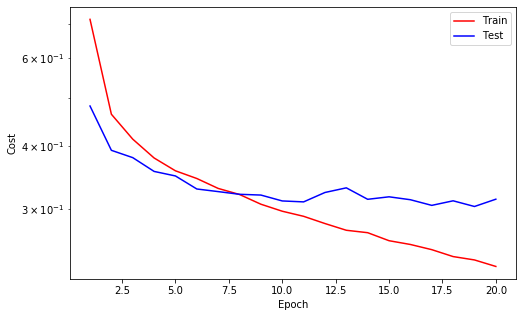

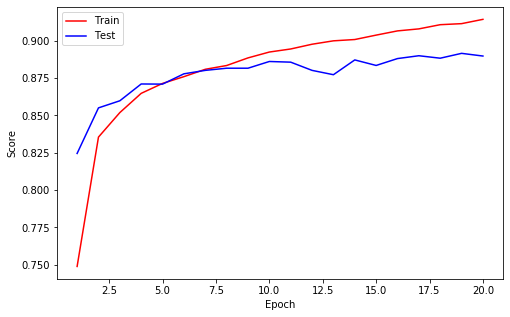

==> EarlyStop patience =  1 | Best test_score: 0.8915




Epoch    21
Train_cost  = 0.2304 | Test_cost  = 0.3121 | Train_score = 0.9131 | Test_score = 0.8907 |
==> EarlyStop patience =  2 | Best test_score: 0.8915




Epoch    22
Train_cost  = 0.2242 | Test_cost  = 0.3021 | Train_score = 0.9155 | Test_score = 0.8940 |




Epoch    23
Train_cost  = 0.2187 | Test_cost  = 0.3084 | Train_score = 0.9188 | Test_score = 0.8916 |
==> EarlyStop patience =  1 | Best test_score: 0.8940




Epoch    24
Train_cost  = 0.2120 | Test_cost  = 0.3196 | Train_score = 0.9213 | Test_score = 0.8912 |
==> EarlyStop patience =  2 | Best test_score: 0.8940




Epoch    25
Train_cost  = 0.2088 | Test_cost  = 0.3131 | Train_score = 0.9205 | Test_score = 0.8922 |
==> EarlyStop patience =  3 | Best test_score: 0.8940




Epoch    26
Train_cost  = 0.2075 | Test_cost  = 0.3184 | Train_score = 0.9220 | Test_score = 0.8912 |
==> EarlyStop patience =  4 | Best test_score: 0.8940




Epoch    27
Train_cost  = 0.2024 | Test_cost  = 0.3210 | Train_score = 0.9243 | Test_score = 0.8901 |
==> EarlyStop patience =  5 | Best test_score: 0.8940
==> Execute Early Stopping at epoch: 27 | Best test_score: 0.8940
==> Best model is saved at model


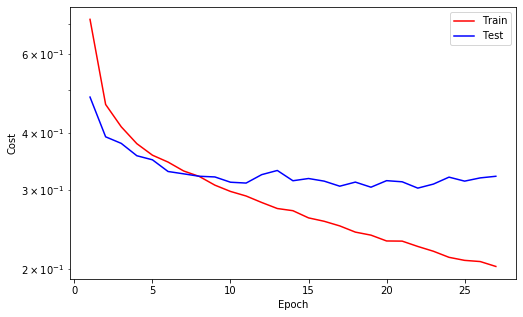

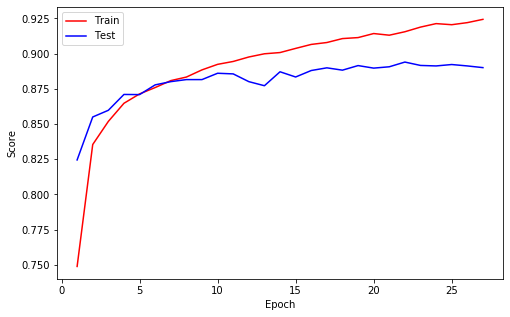

In [0]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)    
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging and Reporting
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

# Load Model Terbaik

In [0]:
# weights = torch.load("model/weights_best.pth", map_location="cpu")
# model.load_state_dict(weights)
# model = model.to(device)

# Sanity Check

In [0]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

In [0]:
images.shape

torch.Size([128, 1, 28, 28])

In [0]:
with torch.no_grad():
    output = model(images)
    preds = output.argmax(1)
preds

tensor([2, 2, 5, 3, 8, 1, 7, 9, 3, 3, 8, 9, 5, 9, 2, 2, 8, 7, 9, 4, 6, 5, 4, 4,
        6, 4, 3, 6, 8, 4, 2, 1, 1, 5, 2, 0, 7, 5, 2, 2, 8, 2, 0, 4, 5, 6, 7, 4,
        8, 7, 6, 2, 1, 5, 8, 7, 8, 8, 9, 2, 8, 3, 0, 5, 1, 6, 4, 4, 3, 5, 0, 3,
        7, 3, 8, 3, 4, 8, 3, 8, 7, 6, 5, 9, 2, 0, 5, 6, 0, 2, 7, 0, 6, 4, 1, 9,
        6, 8, 5, 7, 7, 0, 8, 0, 4, 5, 6, 9, 3, 9, 2, 2, 6, 7, 9, 9, 0, 0, 4, 6,
        6, 5, 3, 3, 2, 2, 6, 8])

# Visualize Prediction

In [0]:
import matplotlib.pyplot as plt

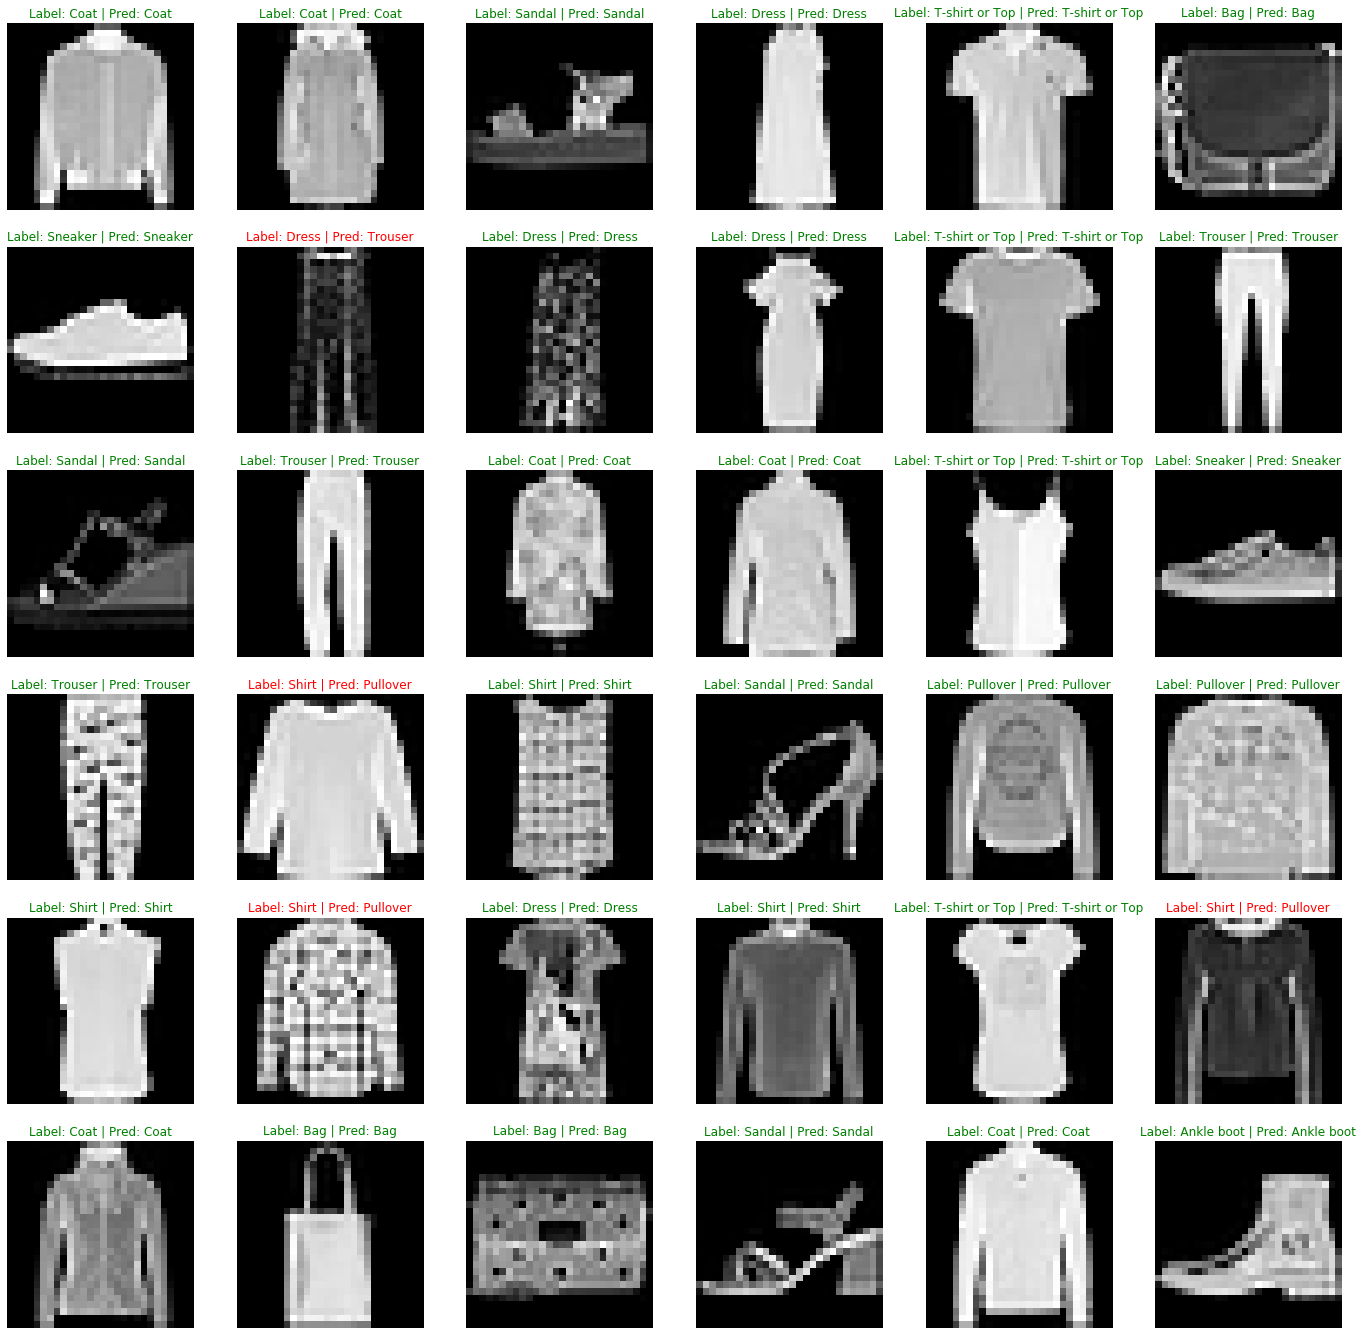

In [0]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap='gray')
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
    ax.axis('off');